Alex Medina | Problem Set #4

- Solving a set of ordinary differential equations to model the structure of solid planets.
- Assume pressure $P(r)$ and density $\rho(r)$ depends only on the distance to the center.
- Equation of hydrostatic equilibrium:

\begin{equation}
\frac{dP(r)}{dr} = -\frac{Gm(r)\rho(r)}{r^2}.
\end{equation}

- And the enclosed mass $m(r)$:

\begin{equation}
\frac{dm(r)}{dr} = 4\pi\rho(r)r^2
\end{equation}

- However, rocky planet interiors, we approximate are described by the equation of state from Seager et al.:

\begin{equation}
\rho(P) = \rho_0 + cP^n
\end{equation}

where $\rho_0$, $c$, and $n$ are constants that depend on the material being modeled. For example, for iron (Fe), $\rho_0 = 8300\ \mathrm{kg\ m^{-3}}$, $c = 0.00349\ \mathrm{kg\ m^{-3}\ Pa^{-n}}$, and $n = 0.528$.

- The values of the dependent variables at $r = 0$ are: $P = P_c$ (the central pressure), and $m = 0$.

**Problem 1:**

- Writing an ODE solver implementing fourth-order Runge-Kutta technique.
- Choose a radial step $\Delta r$, and for final radius, the pressure $P$ will go negative.
- Applying routine to the case $P_c = 10^{12}$ Pa, using Fe for the equation of state.

In [1]:
#Imports

import math as m
import numpy as np
import matplotlib.pyplot as plt

#Constants
G = 6.67408e-11 #In MKS units

In [2]:
#First, creating a general routine for 4th order runge-kutta method

def rk4_step(df, start, delta, values):
    #From the lecture, we know that the coefficients for the output are

    k1 = delta * df (start, values)    
    k2 = delta * df (start + delta/2, values + k1/2)
    k3 = delta * df (start + delta/2, values + k2/2)
    k4 = delta * df (start + delta, values + k3 )

    #return new values y_j + 1
    return values + (1/6)*(k1 + 2*(k2 + k3) + k4)

In [3]:
#Equation of state

class Eqofstate():
    
    def iron(self):
        #Since we only know/want to use iron for now
        self.rho0 = 8300 #kg m^-3
        self.c = 0.00349 #kg m^-3 Pa^-n
        self.n = 0.528
        return
    
    def eos_density(self, pressure):
        #reutnring density in MKS units
        return self.rho0 + self.c * np.maximum(pressure, 0)**float(self.n)
    
    def __init__(self):
        Eqofstate.iron(self)
        return

In [4]:
#Next, I define the derivatives that model hydrostatic equlbrium that we will use RK4 to solve

def hydrostatic_eqs(r, values):
    #Density using the generalized density from the paper
    eos = Eqofstate()
    density = eos.eos_density(values[0])
    
    #Eqs for hydrostatic equilib
    dPdr = - G * density * values[1] / (r**2)
    dmdr = 4 * np.pi * density * r**2
    return np.array([dPdr, dmdr])

#Now to do the integration itself
def hydrostatic_solve(derivs, p_0, delta_0):
    #Derivs are the derivatives for the RK4 solve
    #p_0 is th initial central pressure
    #delta_0 is the initial step size
    
    minstep = 1e-5 * delta_0
 
    delta = delta_0
    #Starting with one step but appending after
    x = np.array([delta])

    eos = Eqofstate()
    dens0 = eos.eos_density(p_0)
    #mass enclosed by central point
    mass0 = (4/3) * np.pi * dens0 * x[0]**3
    pres0 = p_0
    y = np.array([[pres0, mass0]])  

    #Running the solution loop
    while True:
        #Storing these values to check if we should take this step
        ytmp = rk4_step(derivs, x[-1], delta, y[-1])
        
        #Checking to see if pressure has gone negative.
        if ytmp[0] > 0:
            #If the pressure is positive, append values             
            x = np.append(x, x[-1] + delta)
            #make ytmp a 2D slice [[pres, mass]] for appending to y
            y = np.append(y, np.array([ytmp]), axis=0)
            #axis to keep it an array

        else:
            #If the pressure is negative, trying again with smaller step
            delta = delta/2
            #Quiting when reaching the minimum step size
            if delta < minstep: break
            continue
            
    return [x, y]

In [5]:
#Setting up the equation of state and plot result

rEarth = 6.371e6  #m
mEarth = 5.972e24 #kg

#Gives final radius
[r, y] = hydrostatic_solve(hydrostatic_eqs, 1e12, rEarth / 100)

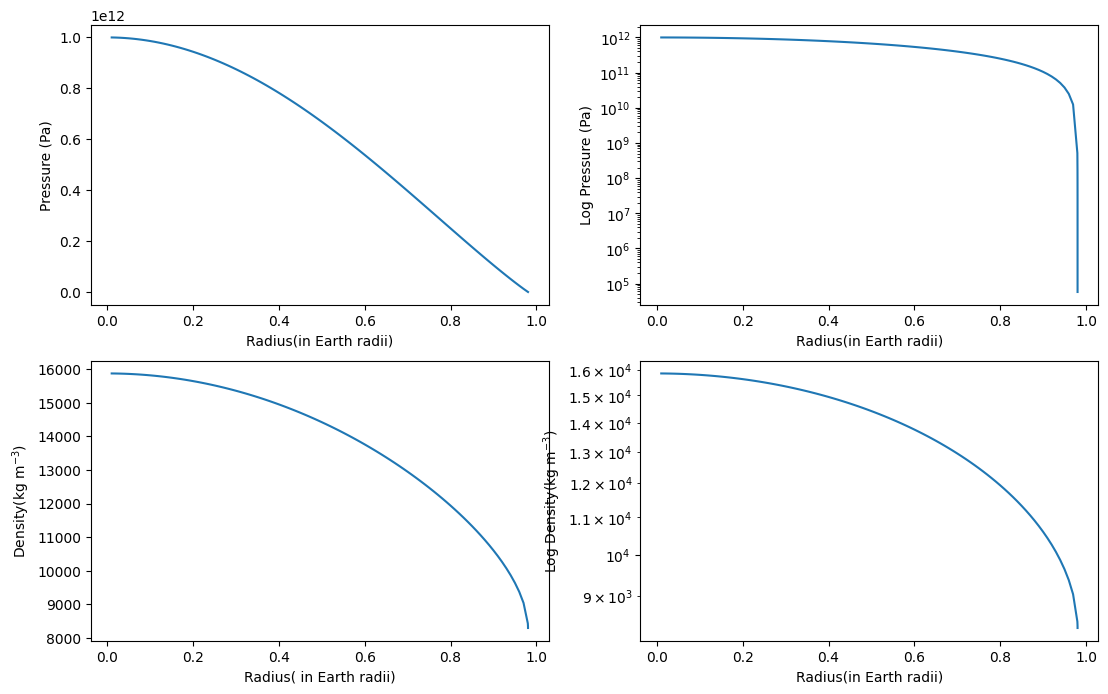

In [17]:
#For normalization of the final radius
rs = r/rEarth

#For completeness
eos = Eqofstate()
eos.iron()

#To fit the window nicely
plt.figure(1, figsize = (13,8))

plt.subplot(221)
plt.plot(rs, y[:,0])
plt.xlabel('Radius(in Earth radii)')
plt.ylabel('Pressure (Pa)')

plt.subplot(222)
plt.plot(rs, y[:,0])
plt.xlabel('Radius(in Earth radii)')
plt.ylabel('Log Pressure (Pa)')
plt.yscale('log')


plt.subplot(223)
plt.plot(rs, eos.eos_density(y[:,0]))
plt.xlabel('Radius( in Earth radii)')
plt.ylabel('Density(kg m$^{-3}$)')

plt.subplot(224)
plt.plot(rs, eos.eos_density(y[:,0]))
plt.xlabel('Radius(in Earth radii)')
plt.ylabel('Log Density(kg m$^{-3}$)')
plt.yscale('log')

plt.show()

**Problem 2:**

- Repeat for a range of central pressures adn ploit in log scale.

Text(0.5, 0, 'Log (Mass / M$_{\\oplus}$)')

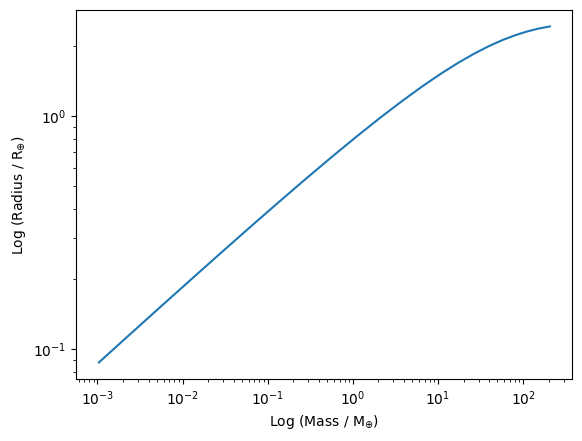

In [7]:
#So for a different range of central pressures

def mass_radius():
    mass = []
    radius = []
    for i in np.arange(1,6.5,0.25) + 8.5:
        [r, y] = hydrostatic_solve(hydrostatic_eqs, 10**i, rEarth/100)
        mass.append(y[-1,1] / mEarth)
        radius.append(r[-1] / rEarth)
    return [mass, radius]

[mass, radius] = mass_radius()

plt.loglog(mass, radius)
plt.ylabel('Log (Radius / R$_{\oplus}$)')
plt.xlabel('Log (Mass / M$_{\oplus}$)')

**Problem 3:**
Repeat problem 2, but instead of Fe, use H20 and MgSi03 (see Table 3 of the Seager et al. paper referenced earlier). Plot the three resulting M-R relations (for the three materials mentioned) and also plot points for the solar system's terrestrial planets (Mercury, Venus, Earth and Mars), and some exoplanet data see, for example, Table 1 of arxiv.org/pdf/1312.0936v4.pdf (you dont have to plot all of those exoplanets a small selection is fine). Use the routine errorbar to plot the errors in mass (note that you'll want to specify something like linestyle = 'None' , marker = 'x', color = 'red', since errorbar doesn't take specications like 'rx' like plot does). Comment on the results that you find.

In [18]:
#Creating new class to add new materials

class N_Eqofstate():
    
    def iron(self):
        #Since we only know/want to use iron for now
        self.rho0 = 8300 #kg m^-3
        self.c = 0.00349 #kg m^-3 Pa^-n
        self.n = 0.528
        return
    
    #MgSiO3
    def mgsio(self):
        self.rho0 = 4100 #kg m^-3
        self.c = 0.00161 #kg m^-3 Pa^-n
        self.n = 0.541
        return
    
    #Water
    def water(self):
        self.rho0 = 1460 #kg m^-3
        self.c = 0.00311 #kg m^-3 Pa^-n
        self.n = 0.513
        return
    
    
    def eos_density(self, pressure):
        #reutnring density in MKS units
        return self.rho0 + self.c * np.maximum(pressure, 0)**float(self.n)
    
    def __init__(self):
        N_Eqofstate.iron(self)
        return

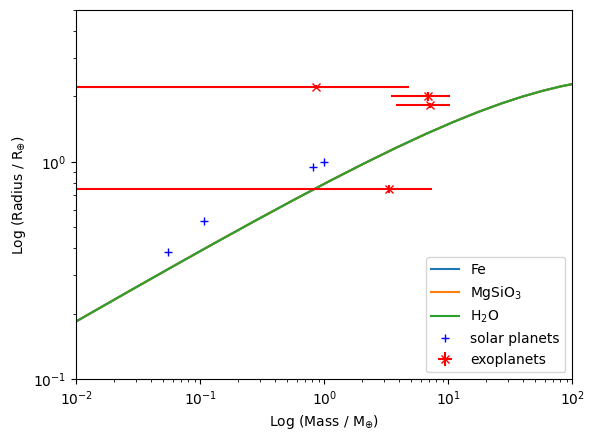

In [19]:
#Putting the pieces together

neos = N_Eqofstate()
neos.mgsio()
[mper, rper] = mass_radius()
neos.water()
[mwater, rwater] = mass_radius()

#Masses (kg) and radii (m) of Mercury, Venus, Earth, Mars
planet_mass = np.array([3.30e23, 4.87e24, 5.97e24, 6.42e23])
planet_radius = np.array([2440e3, 6052e3, 6378e3, 3397e3])

#Masses (in earth masses) and radii (earth) of Kepler-18b, Kepler-37c, Kepler-100 c and Kepler-113 b
exoplanet_mass = np.array([6.90, 3.35, 0.85, 7.10])
exo_mass_error = np.array([3.48, 4.0,  4.0,  3.30])
exoplanet_radius = np.array([2.00, 0.75, 2.20, 1.82])
exo_radius_error = np.array([0.1,  0.03, 0.05, 0.05])


plt.plot(mass, radius, label = 'Fe')
plt.plot(mper, rper, label = 'MgSiO$_3$')
plt.plot(mwater, rwater, label = 'H$_2$O')
plt.plot(planet_mass/mEarth, planet_radius/rEarth, 'b+',  label='solar planets')

#Plot errorbars for exoplanets (note different way of specifying point & line information)
plt.errorbar(exoplanet_mass, exoplanet_radius, ls = 'None', color = 'r', marker = 'x', 
           label='exoplanets', xerr = exo_mass_error, yerr = exo_radius_error)

plt.xlim([1e-2,10**2])
plt.ylim([0.1,5])             

fs = 'xx-large'
plt.xlabel('Log (Mass / M$_{\oplus}$)')
plt.ylabel('Log (Radius / R$_{\oplus})$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')

plt.show()